<a href="https://colab.research.google.com/github/Priya1Projects/MSBA_DataScience/blob/main/NLPJobSkillsExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import gensim.utils
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [28]:
nltk.download('stopwords')
import pandas as pd
stop_words = set(stopwords.words("english"))
stop = stopwords.words("english")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
import itertools
from google.colab import drive
drive.mount('/content/drive')


In [64]:
# Helper method
#function to normalize description tokenize remove stopwords
def norm(desc):
    desc = str(desc)
    desc = re.sub('[^a-zA-Z]',' ',desc)
    desc = desc.lower()
    desc = re.sub(pattern='\s+', repl=' ', string=desc)    
    desc = nltk.word_tokenize(desc)   
    return desc


# Get  the nouns / proper nouns / adjectives
def postagwords(tagged_stanzas):
  chunkGram = r"""NP: {<NN>+<PUNCT>+}"""
  chunkGram = r"""chunk: {<JJ>+}"""
  chunkGram = r"""chunk: {<NN>+<NN>+<NN>+}"""
  #Chunk 3: Sequence of Nouns
  chunkGram = r"""chunk: {<NN|NNP|NNS|NNPS>+}"""
  chunkGram = r"""NP: {<NN|NNP|NNS|NNPS>+}"""
  chunkParser = nltk.RegexpParser(chunkGram)
  nouns = [] 
  finalpos= []

  for i in tagged_stanzas:  
    tree1 = chunkParser.parse(i)
    nouns = [(word) for (word, pos) in i if pos == 'NN' or pos == 'NNS' or pos=='NNP' or pos=='JJ'] 
    finalpos.append(nouns)

  flat_list = list(itertools.chain(*finalpos))
  return flat_list



#Skills Frequency
def most_frequent_skills(flat_list):
  tag_fd = nltk.FreqDist(flat_list)
  countsskills = pd.DataFrame(tag_fd.items(), columns=['word', 'frequency'])
  # print('before')
  # print(countsskills)
  countsskills =countsskills[countsskills['word'].isin(['statistics', 'machine',  'r', 'python', 'nlp',  'neural','forecasting','tableau','power','bi',
                        'software','programming'  'cloud' , 'aws','sas','regression','predictive', 'modeling','clustering' ,'database','databases',
                        'datawarehouse','excel','pytorch','gcp','ETL','business','visualization','macros','operations','documentation','azure','ops','microsoft','powerpoint'
                        'communication','interpersonal','storytelling','marketing','terradata','splunk','ruby','spark','cassandra','mongodb','scala','api','segmentation','targeting',
                        'reporting','quality','a/b','html','css','sales','visio','logistics'
                        'project','access','qa','quality','agile','scrum','jira'])]
  countsskills.sort_values(by=['frequency'],ascending=False)
  # print('after')
  # print(countsskills)
  return countsskills[:30]


In [6]:
job_df=pd.read_excel('drive/My Drive/All_Jobs_Scraped.xlsx')
print(len(job_df))


2949


In [8]:
job_df['Description']

0       DescriptionJOIN US AS A SR DATA ANALYST – DATA...
1       POSITION PURPOSEA Senior Data Analyst, Supply ...
2       Note: By applying to this position you will ha...
3       Job Summary And MissionThis job contributes to...
4       Note: By applying to this position you will ha...
                              ...                        
2944    What is Contentstack?ContentstackⓇ – the pione...
2945    Participate in a variety of assigned and ongoi...
2946    TD DescriptionAbout TD Bank, America's Most Co...
2947    Are you passionate about Project Management? A...
2948    Corporate ProfileRegent is a leading Software-...
Name: Description, Length: 2949, dtype: object

In [ ]:
#running function on description column
job_df_Desc=job_df['Description'].apply(lambda x:norm(x))
job_df_Desc

In [10]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
#removing stopwords from description 
stop= nltk.corpus.stopwords.words('english')
new=['job','note','sexual','orientation','equal','opportunity','gender','plus','years','scientist','analyst','based','data','knowledge','discrimination','experience','description','summary','information','etc','eg','layers']
stop.extend(new)
job_df_clean=job_df_Desc.apply(lambda x:[item for item in x if item not in set(stop)])


In [12]:
job_df.loc[:,'tokenized_Description'] = job_df_clean

In [30]:
job_df.loc[:,'tokenized_Description']

0       [descriptionjoin, us, sr, sciences, analyticsa...
1       [position, purposea, senior, supply, chain, le...
2       [applying, position, share, preferred, working...
3       [missionthis, contributes, starbucks, success,...
4       [applying, position, share, preferred, working...
                              ...                        
2944    [contentstack, contentstack, pioneering, agile...
2945    [participate, variety, assigned, ongoing, busi...
2946    [td, descriptionabout, td, bank, america, conv...
2947    [passionate, project, management, looking, mak...
2948    [corporate, profileregent, leading, software, ...
Name: tokenized_Description, Length: 2949, dtype: object

In [14]:
import gensim.utils
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

In [15]:
#Topic Modeling
# !pip install spacy
# !pip install pyLDAvis
# !pip install --upgrade gensim
import re
import numpy as np
import pandas as pd
import nltk
import sklearn
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# # Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim_models as plt_gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [16]:
df = job_df
df["Description"] = df["Description"].fillna("")
df["tokenized_Description"]

0       [descriptionjoin, us, sr, sciences, analyticsa...
1       [position, purposea, senior, supply, chain, le...
2       [applying, position, share, preferred, working...
3       [missionthis, contributes, starbucks, success,...
4       [applying, position, share, preferred, working...
                              ...                        
2944    [contentstack, contentstack, pioneering, agile...
2945    [participate, variety, assigned, ongoing, busi...
2946    [td, descriptionabout, td, bank, america, conv...
2947    [passionate, project, management, looking, mak...
2948    [corporate, profileregent, leading, software, ...
Name: tokenized_Description, Length: 2949, dtype: object

In [35]:
#remove stopwords 
import regex as re
df['tokenized_desc_join'] = [' '.join(map(str, l)) for l in df['tokenized_Description']]

df


,Role Category,JobId,JobTitle,Source,Company,Description,PayRange,Skills,Location,HiringTimeLine,WhenPosted,tokenized_Description,tokenized_desc_join,Skills1,Skills2,Skills3,Skills4,Skills5
0,Data Science,8e6031ee-dcfa-11ec-8afa-e1f3faa1d563,Sr Data Analyst/Data Science Analytics (Full-T...,Linkedln,Target,DescriptionJOIN US AS A SR DATA ANALYST – DATA...,"$118,100",Python,"Minneapolis, MN",Actively Hiring,22 hours ago,"[descriptionjoin, us, sr, sciences, analyticsa...",descriptionjoin us sr sciences analyticsabout ...,business,reporting,NaN,NaN,NaN
1,Data Science,905e37ac-dcfa-11ec-81ff-e1f3faa1d563,"Senior Data Analyst, Supply Chain Analytics (R...",Linkedln,The Home Depot,"POSITION PURPOSEA Senior Data Analyst, Supply ...",0,Python,"Atlanta, GA",Actively Hiring,2 days ago,"[position, purposea, senior, supply, chain, le...",position purposea senior supply chain leverage...,business,statistics,machine,excel,access
2,Data Science,925b1906-dcfa-11ec-b89e-e1f3faa1d563,"Business Data Scientist, Search Analytics",Linkedln,Google,Note: By applying to this position you will ha...,0,Python,"New York, NY",Actively Hiring,1 week ago,"[applying, position, share, preferred, working...",applying position share preferred working loca...,business,NaN,NaN,NaN,NaN
3,Data Science,9458a168-dcfa-11ec-8959-e1f3faa1d563,"Sr. Data Scientist, People Analytics – Remote",Linkedln,Starbucks,Job Summary And MissionThis job contributes to...,"$117,000.00/yr - $174,000.00/yr",Python,"Seattle, WA",Actively Hiring,3 weeks ago,"[missionthis, contributes, starbucks, success,...",missionthis contributes starbucks success guid...,business,quality,NaN,NaN,NaN
4,Data Science,9664a9d0-dcfa-11ec-94b0-e1f3faa1d563,"Business Data Scientist, Search Analytics",Linkedln,Google,Note: By applying to this position you will ha...,0,Python,"San Francisco, CA",Actively Hiring,1 week ago,"[applying, position, share, preferred, working...",applying position share preferred working loca...,business,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,Operations,cffd53ed-e62e-11ec-ad8e-00051baa7975,Business Analyst - Success Operations,Linkedln,Contentstack,What is Contentstack?ContentstackⓇ – the pione...,0,Python,United States,Actively Hiring,14 hours ago,"[contentstack, contentstack, pioneering, agile...",contentstack contentstack pioneering agile con...,NaN,NaN,NaN,NaN,NaN
2945,Operations,d260a22c-e62e-11ec-953f-00051baa7975,Business Analyst,Linkedln,Compunnel Inc.,Participate in a variety of assigned and ongoi...,0,Python,"Charlotte, NC",Actively Hiring,15 hours ago Apply Now,"[participate, variety, assigned, ongoing, busi...",participate variety assigned ongoing business ...,NaN,NaN,NaN,NaN,NaN
2946,Operations,d47969ef-e62e-11ec-96b8-00051baa7975,Business Process Analyst II (US),Linkedln,TD,"TD DescriptionAbout TD Bank, America's Most Co...",0,Python,"Atlanta, GA",Be an early applicant,3 days ago,"[td, descriptionabout, td, bank, america, conv...",td descriptionabout td bank america convenient...,NaN,NaN,NaN,NaN,NaN
2947,Operations,d6abe9cb-e62e-11ec-8197-00051baa7975,"Analyst, Supply Chain Solutions",Linkedln,CJ Logistics America,Are you passionate about Project Management? A...,0,Python,"Des Plaines, IL",Actively Hiring,2 weeks ago Apply Now,"[passionate, project, management, looking, mak...",passionate project management looking make imp...,NaN,NaN,NaN,NaN,NaN


In [18]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [54]:
df['Skills5'][999:2000]
df=df[df['Role Category'] == 'Data Science']
len(df)

1000

In [66]:
# POS Tag matching
tagged_stanzas = []
tagged = []
wrdcld=[]
i=0
for row in df['tokenized_Description'][:1000]:
    #POS tag generator
    tagged_word = nltk.pos_tag(row)    
    tagged_stanzas.append(tagged_word)
    #Rule based matching
    finalpostagged = postagwords(tagged_stanzas)  
    
    #Top skills extraction   
    skills= most_frequent_skills(finalpostagged)
    
    k=0
    for j in skills['word']:      
      index= str('Skills')+str(k+1)
      wrdcld.append(j)
      k=k+1
      df.loc[i,index]= j      
    i=i+1
    tagged_stanzas =[]
    

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged.append(tagged_stanzas)


In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
import spacy
from spacy import displacy

for sentence in df['Description'].sample(5, random_state = 10):
    sentence_doc = nlp(sentence[:89])
  
    displacy.render(sentence_doc, style='dep', jupyter=True)
    print("Sentence is: ", sentence_doc)

In [ ]:
test="B.S. in Computer Science, Math, Engineering, Finance, or related quantitative field.Work experience with MS Excel, MS Access, SQL Server, Teradata, Oracle, or comparable database systems."

sentence_doc = nlp(test)

displacy.render(sentence_doc, style='dep', jupyter=True)
print("Sentence is: ", sentence_doc)

Sentence is:  B.S. in Computer Science, Math, Engineering, Finance, or related quantitative field.Work experience with MS Excel, MS Access, SQL Server, Teradata, Oracle, or comparable database systems.


In [ ]:
test="We are looking for a highly-skilled Data Scientist with experience performing statistical analysis, predictive analytics, and attribution modeling among others. The role will be involved in things like helping identify important user subgroups, informing ad spend, email targeting, and A/B testing"
sentence_doc = nlp(test)
options={'compact' :True,'color':'green'}
displacy.render(sentence_doc, style='dep', jupyter=True, options=options)
print("Sentence is: ", sentence_doc)

Sentence is:  We are looking for a highly-skilled Data Scientist with experience performing statistical analysis, predictive analytics, and attribution modeling among others. The role will be involved in things like helping identify important user subgroups, informing ad spend, email targeting, and A/B testing


In [ ]:
#!pip install openpyxl
df.to_excel("drive/My Drive/jobswithskills.xlsx")

In [81]:
finalpostagged
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
#convert list to string and generate
unique_string=(" ").join(wrdcld)
stop_words = ['business','analytic','team', 'product','analytics','customer','operations','quality','marketing']
wordcloud = WordCloud(width = 1000, height = 500,stopwords = stop_words,mask=mask,background_color='navy', colormap='rainbow').generate(unique_string)


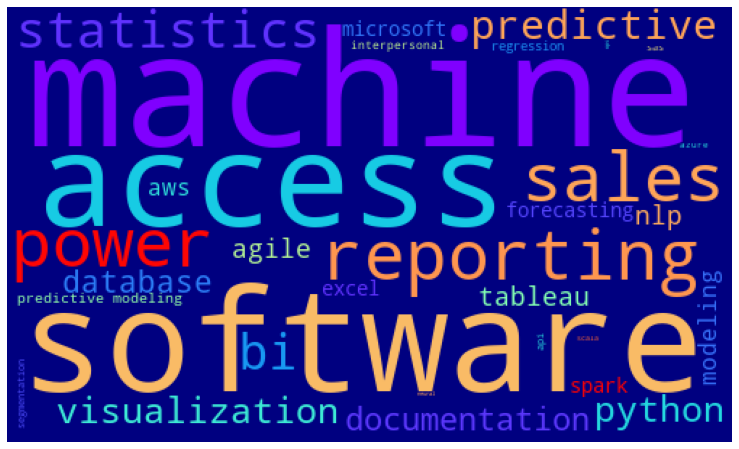

In [96]:
wordcloud =  WordCloud(width = 500, height = 300,stopwords = stop_words,background_color='navy', colormap='rainbow').generate(unique_string)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()


In [21]:
model = Word2Vec(df['tokenized_Description'] ,
                               window=10, 
                               min_count=10, 
                               workers=5,size = 500)
model.train(df['tokenized_Description'] ,total_examples=700,epochs=model.epochs)
model.build_vocab(df['tokenized_Description'],progress_per=100,update=True)


In [ ]:
model1 = Word2Vec(df['tokenized_Description'] ,
                               window=10, 
                               min_count=10, 
                               workers=5,size = 500)
model1.train(finalpos,total_examples=700,epochs=model.epochs)
model1.build_vocab(df['tokenized_Description'],progress_per=100,update=True)

In [ ]:
['statistics', 'machine', 'deep', 'learning', 'r', 'python',
                      'business', 'software',  'cloud' , 'aws','sas','regression','predictive', 'modeling','clustering','time','series' ]

In [97]:
# data science specific skills
model.wv.most_similar(['statistics', 'machine', 'deep', 'learning', 'r', 'python',
                      'business', 'software',  'cloud' , 'aws','sas','regression','predictive', 'modeling','clustering','time','series' ],topn=25)

[('programming', 0.8478977680206299),
 ('statistical', 0.8173484802246094),
 ('sql', 0.8145798444747925),
 ('hadoop', 0.8121113777160645),
 ('ml', 0.811629056930542),
 ('mining', 0.8081516623497009),
 ('inference', 0.8034366369247437),
 ('spss', 0.8018981218338013),
 ('libraries', 0.7946780323982239),
 ('alteryx', 0.7944015264511108),
 ('insightsexperience', 0.7911970615386963),
 ('scripting', 0.7808064222335815),
 ('querying', 0.7723453044891357),
 ('nlp', 0.7709598541259766),
 ('linear', 0.7707847952842712),
 ('familiarity', 0.7652961015701294),
 ('techniques', 0.7651718854904175),
 ('advanced', 0.7585494518280029),
 ('java', 0.7573983669281006),
 ('modelling', 0.7523831129074097),
 ('manipulating', 0.7477168440818787),
 ('qlik', 0.7391512393951416),
 ('relational', 0.738558292388916),
 ('requiredexperience', 0.7351810336112976),
 ('analysisexperience', 0.7349435091018677)]

In [ ]:
model.wv.most_similar(['python'],topn=30,)

[('programming', 0.9378111362457275),
 ('r', 0.9121090769767761),
 ('dataexperience', 0.8899893760681152),
 ('spreadsheet', 0.8876073360443115),
 ('languages', 0.8853429555892944),
 ('scala', 0.8733975887298584),
 ('familiarity', 0.8718503713607788),
 ('sas', 0.8687570095062256),
 ('java', 0.8623289465904236),
 ('proficiency', 0.8621343374252319),
 ('proficient', 0.8566124439239502),
 ('linux', 0.8564294576644897),
 ('scripting', 0.8535560965538025),
 ('distributed', 0.8479576110839844),
 ('command', 0.8461756706237793),
 ('plusexperience', 0.8456171751022339),
 ('sql', 0.8449390530586243),
 ('analyticsexperience', 0.8420359492301941),
 ('pythonexperience', 0.8410766124725342),
 ('snowflake', 0.8308957815170288),
 ('similar', 0.8288989663124084),
 ('least', 0.8274185657501221),
 ('skillsexperience', 0.826460599899292),
 ('relational', 0.8247244954109192),
 ('database', 0.8228758573532104),
 ('pyspark', 0.8222407698631287),
 ('coding', 0.8221794366836548),
 ('stata', 0.8211449384689331)

In [ ]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

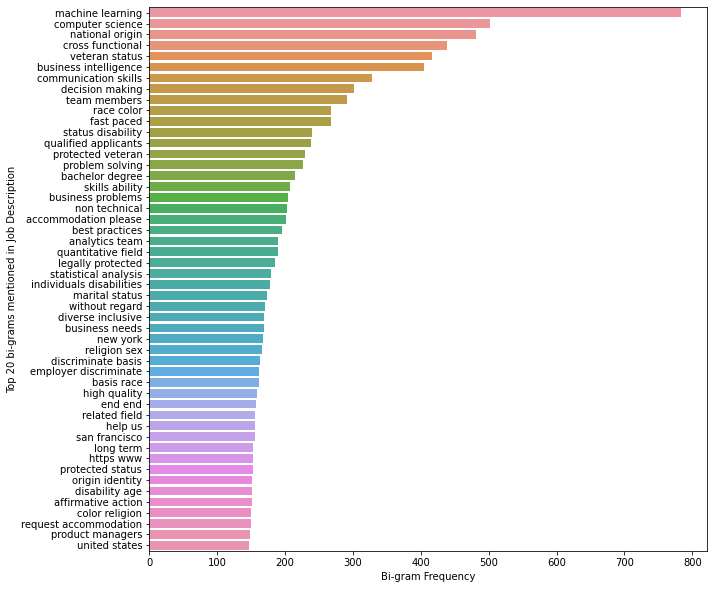

In [ ]:
#n-grams in description 

def plot_top_ngrams_barchart(text, n=3):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:50]

    top_n_bigrams=_get_top_ngram(text,n)[:50]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel("Bi-gram Frequency")
    plt.ylabel("Top 20 bi-grams mentioned in Job Description")
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(df['tokenized_desc_join'],2)
plt.show()